In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import scipy
import scanpy as  sc
import anndata as ad
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=UserWarning, message="ImplicitModificationWarning")
print('import successful')

import successful


In [2]:
####global variable###


In [3]:
datasets = ['M-MG','R-MG','S-MG','R-AG','S-AG','R-CG']
#datasets = ['R-MG','R-AG']
use_hvg=True
n_top_genes=3000
adata_list=[]
################

In [4]:
for dataset in datasets:
    #path = f'D:/111/{dataset}_cleaned.h5ad'
    path = f'../../{dataset}/1.subset/{dataset}_cleaned.h5ad'
    adata = ad.read_h5ad(path)
    adata.X=adata.layers["counts"]
    adata.obs = adata.obs.drop(columns=["cellid"])
    adata_list.append(adata)
    del adata

In [5]:
adata_combined = adata_list[0].concatenate(*adata_list[1:],join='outer',batch_key='dataset')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14868\3375051885.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_list[0].concatenate(*adata_list[1:],join='outer',batch_key='dataset')


In [6]:
adata_combined.obs['celltype_dataset']= (adata_combined.obs['newcelltype'].astype(str)
                                         + "_" + adata_combined.obs['species'].astype(str)
                                         + "_" + adata_combined.obs['gland'].astype(str))

In [7]:
adata_combined.write('all_lum.h5ad')

In [ ]:
if use_hvg:
    sc.pp.normalize_total(adata_combined)
    sc.pp.log1p(adata_combined)
    sc.pp.highly_variable_genes(adata_combined, n_top_genes=n_top_genes)
    adata_combined = adata_combined[:, adata_combined.var.highly_variable]
    sc.pp.scale(adata_combined, max_value=10)

In [8]:
celltype_datasets=adata_combined.obs['celltype_dataset'].unique()
celltype_datasets

['StemCells_R_MG', 'Lum3_R_MG', 'NA_R_MG', 'Lum2_R_MG', 'Lum1_R_MG', ..., 'NA_R_AG', 'Lum4_R_AG', 'Lum3_R_AG', 'StemCells_R_AG', 'Lum2_R_AG']
Length: 12
Categories (12, object): ['Lum1_R_AG', 'Lum1_R_MG', 'Lum2_R_AG', 'Lum2_R_MG', ..., 'NA_R_AG', 'NA_R_MG', 'StemCells_R_AG', 'StemCells_R_MG']

In [19]:

celltype_subsets = {
    celltype: adata_combined[adata_combined.obs['celltype_dataset'] == celltype]
    for celltype in celltype_datasets
}

# 存储结果
correlation_results = []

for celltype1 in celltype_datasets:
    for celltype2 in celltype_datasets: 
        subset_gland1 = celltype_subsets[celltype1]
        subset_gland2 = celltype_subsets[celltype2]

        if subset_gland1.shape[0] <= 1 or subset_gland2.shape[0] <= 1:
            print(f"{celltype1} or {celltype2} has too few samples, skipping correlation.")
            continue

        subset_gland1.X = np.nan_to_num(subset_gland1.X, nan=0.0)
        subset_gland2.X = np.nan_to_num(subset_gland2.X, nan=0.0)

        mean_expression_gland1 = np.asarray(subset_gland1.X.mean(axis=0)).flatten()
        mean_expression_gland2 = np.asarray(subset_gland2.X.mean(axis=0)).flatten()

        corr, pval = spearmanr(mean_expression_gland1, mean_expression_gland2)

        # 保存结果
        correlation_results.append({
            'celltype1': celltype1,
            'celltype2': celltype2,
            'correlation': corr,
            'p-value': pval
        })
        print(f'{celltype1} vs {celltype2} correlation: {corr}, p-value: {pval}')


correlation_df = pd.DataFrame(correlation_results).dropna()
correlation_df = correlation_df[correlation_df['p-value'] < 0.05]
print(correlation_df)

C:\Users\Lenovo\miniconda3\envs\py310\lib\site-packages\anndata\_core\anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


StemCells_R_MG vs StemCells_R_MG correlation: 1.0, p-value: 0.0
StemCells_R_MG vs Lum3_R_MG correlation: 0.8943041293305573, p-value: 0.0
StemCells_R_MG vs NA_R_MG correlation: 0.9035379692179989, p-value: 0.0
StemCells_R_MG vs Lum2_R_MG correlation: 0.8629722829020879, p-value: 0.0
StemCells_R_MG vs Lum1_R_MG correlation: 0.8481548321765109, p-value: 0.0
StemCells_R_MG vs Lum4_R_MG correlation: 0.809059205812796, p-value: 0.0
StemCells_R_MG vs Lum1_R_AG correlation: 0.800224223743143, p-value: 0.0
StemCells_R_MG vs NA_R_AG correlation: 0.8890620189539421, p-value: 0.0
StemCells_R_MG vs Lum4_R_AG correlation: 0.8798043554614823, p-value: 0.0
StemCells_R_MG vs Lum3_R_AG correlation: 0.890822735343321, p-value: 0.0
StemCells_R_MG vs StemCells_R_AG correlation: 0.8415759034221717, p-value: 0.0
StemCells_R_MG vs Lum2_R_AG correlation: 0.8424362598262132, p-value: 0.0
Lum3_R_MG vs StemCells_R_MG correlation: 0.8943041293305573, p-value: 0.0
Lum3_R_MG vs Lum3_R_MG correlation: 1.0, p-value: 

In [18]:
enumerate(celltype_datasets)

In [20]:
correlation_matrix = correlation_df.pivot(index='celltype1', columns='celltype2', values='correlation')
correlation_matrix.to_csv('correlation_matrix.csv')

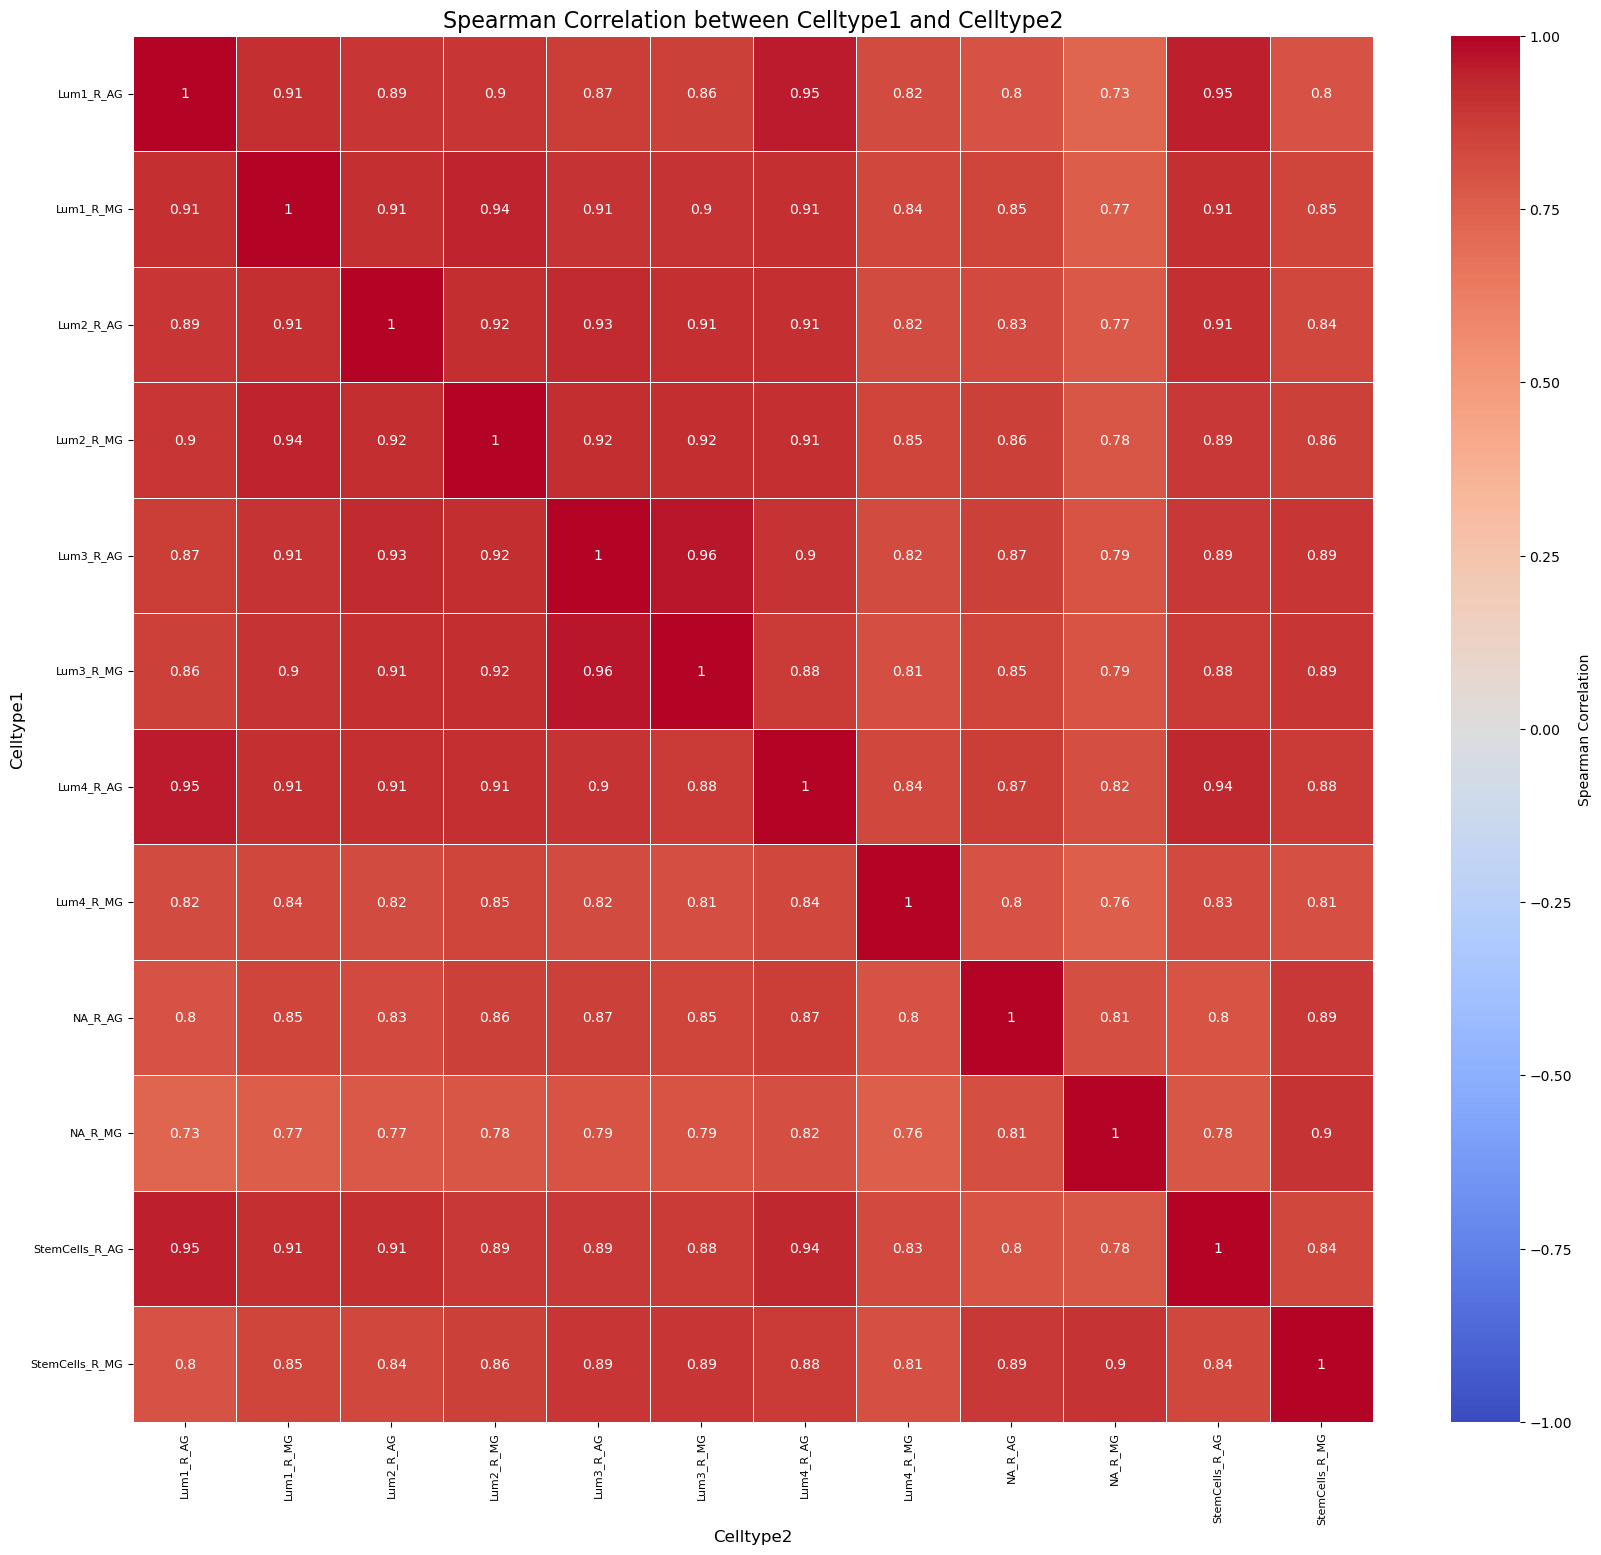

In [21]:
plt.figure(figsize=(20,18))  # 调整图像大小
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            cbar_kws={'label': 'Spearman Correlation'}, linewidths=0.5)
plt.title('Spearman Correlation between Celltype1 and Celltype2', fontsize=16)
plt.xlabel('Celltype2', fontsize=12)
plt.ylabel('Celltype1', fontsize=12)

# 调整坐标轴标签的旋转角度和大小
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# 保存图像
plt.savefig('heatmap_correlation.png', dpi=300, bbox_inches='tight')  # 保存图像
plt.show()  # 显示图像

<Figure size 2000x1800 with 0 Axes>

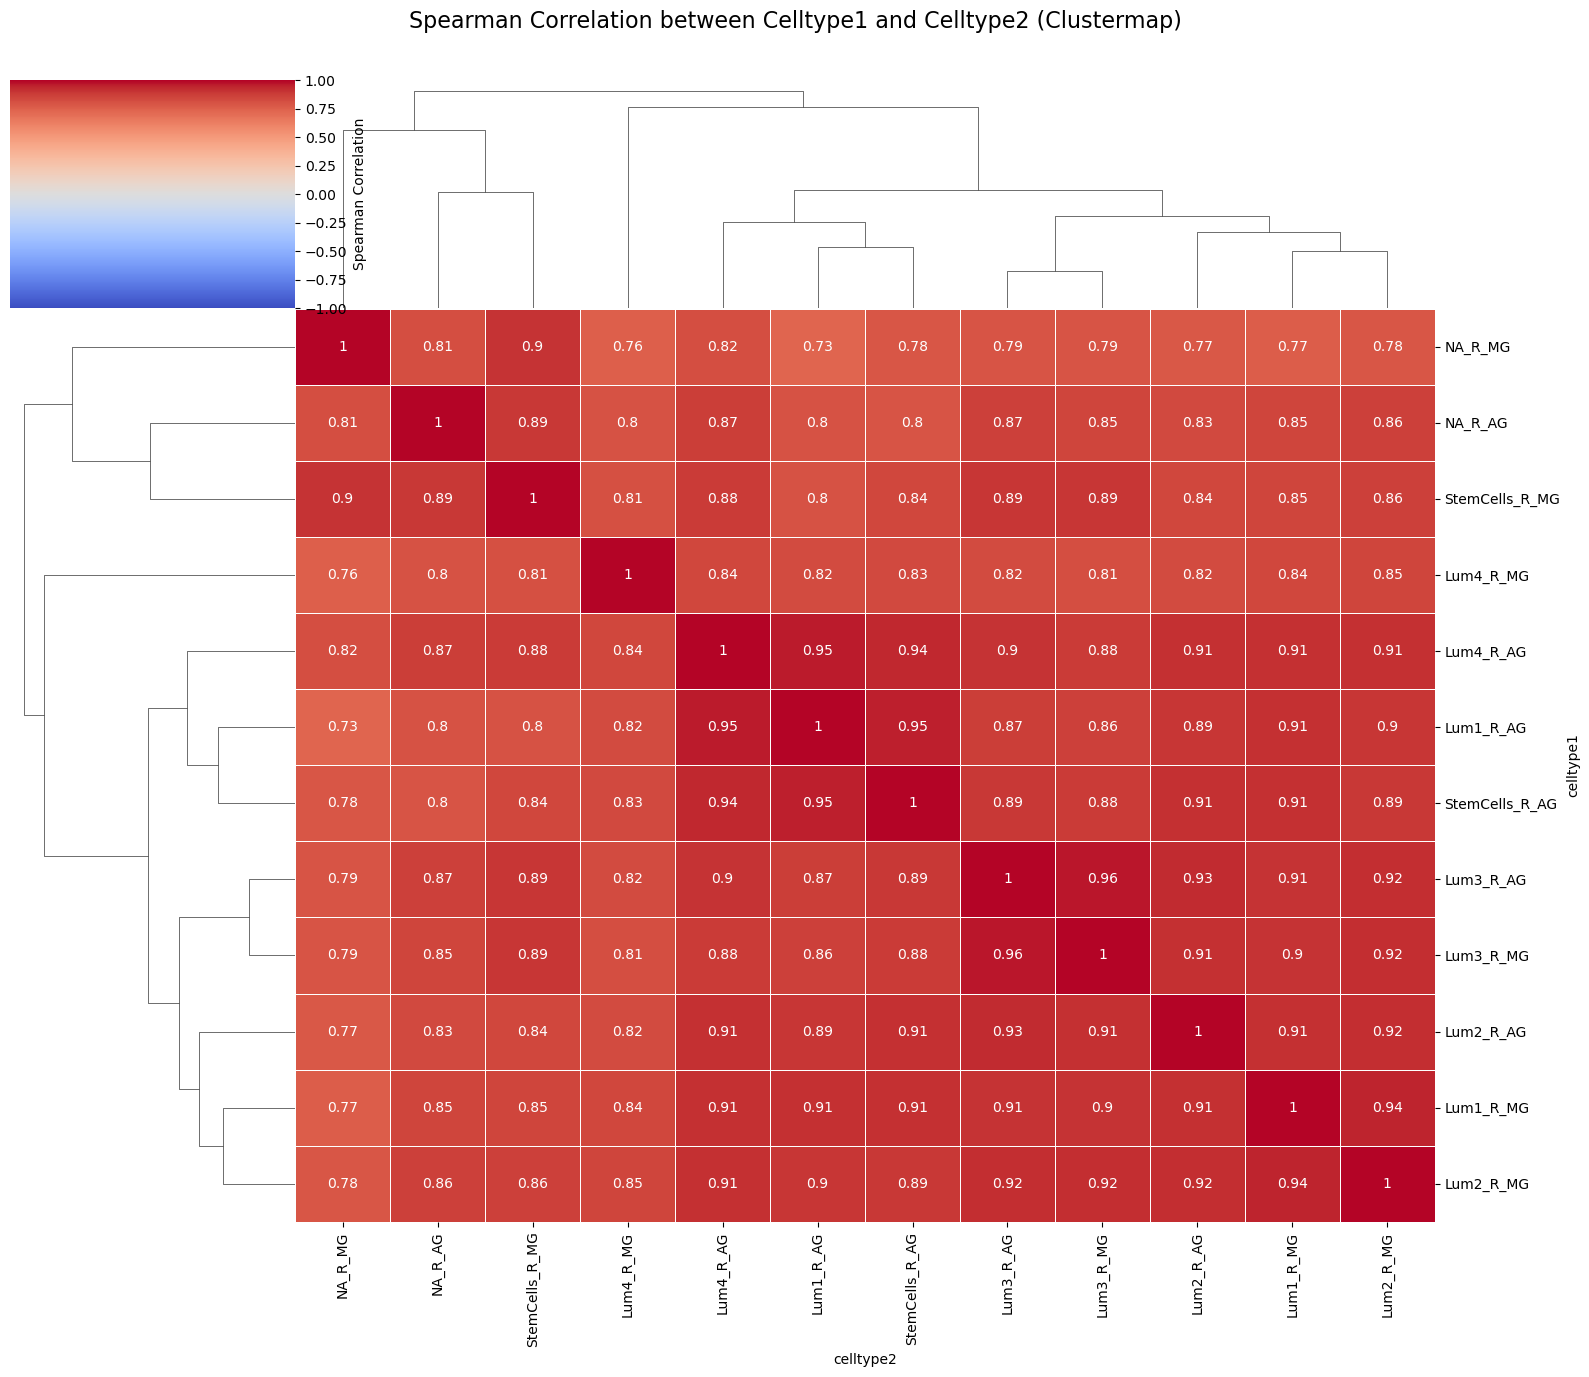

In [22]:
correlation_matrix1= correlation_matrix.fillna(0)
# 使用 Seaborn 绘制带聚类的热图
plt.figure(figsize=(20,18))  # 调整图像大小
sns.clustermap(correlation_matrix1, annot=False, cmap='coolwarm', vmin=-1, vmax=1, 
               figsize=(16, 14), cbar_kws={'label': 'Spearman Correlation'}, 
               linewidths=0.5, row_cluster=True, col_cluster=True)

# 设置标题和保存图像
plt.suptitle('Spearman Correlation between Celltype1 and Celltype2 (Clustermap)', fontsize=16)
plt.subplots_adjust(top=0.93)  # 调整标题位置，避免与热图重叠

plt.savefig('heatmap_correlation-cluster.png', dpi=300, bbox_inches='tight')  # 保存图像
plt.show()  # 显示图像
